In [141]:
import numpy as np
import pandas as pd
import pingouin as pg
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

from dataset import Dataset
dataset = Dataset('connectivity_scores_ncn-4_wpli', novice_excludes=["14"])

In [142]:
def plot_ps(ps_group, ps_condition, ps_interaction, channel_names, title="P Values", sub_title_1="Group", sub_title_2="Condition", sub_title_3="Interaction"):
    fig, axs = plt.subplots(1, 3, figsize=(25, 10), )

    # Define a colormap that goes from bright yellow (at 0) to darker as it approaches 0.05
    cmap = plt.get_cmap('inferno_r')

    # Set vmin and vmax for the color scale (0.05 to 0)
    vmin, vmax = 0, 0.5

    # Helper function to annotate the cells with their values
    def annotate_heatmap(im, data):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i, j] > 0.1:
                    continue
                if np.isnan(data[i, j]):
                    continue
                text = im.axes.text(j, i, f"{data[i, j]:.2f}",
                                    ha="center", va="center", color="black")

    # Group p values
    im0 = axs[0].imshow(ps_group[:, :], cmap=cmap, vmin=vmin, vmax=vmax)
    annotate_heatmap(im0, ps_group[:, :])
    axs[0].set_title(sub_title_1, fontsize=20)

    # Condition p values
    im1 = axs[1].imshow(ps_condition[:, :], cmap=cmap, vmin=vmin, vmax=vmax)
    annotate_heatmap(im1, ps_condition[:, :])
    axs[1].set_title(sub_title_2, fontsize=20)

    # Interaction p values
    im2 = axs[2].imshow(ps_interaction[:, :], cmap=cmap, vmin=vmin, vmax=vmax)
    annotate_heatmap(im2, ps_interaction[:, :])
    axs[2].set_title(sub_title_3, fontsize=20)

    # Create a single color bar that spans all subplots
    fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

    # Set the x and y labels
    for ax in axs:
        ax.set_xticks(range(len(channel_names)))
        ax.set_xticklabels(channel_names, rotation=90)
        ax.set_yticks(range(len(channel_names)))
        ax.set_yticklabels(channel_names)

    # Set the overall title
    fig.suptitle(title, fontsize=30)

    # plt.show()
    return fig
    

In [143]:
def get_ps(freq_band, demo):
    expert_NoG = dataset.get_frequency_average("expert", demo, "NoG", freq_band)
    expert_WiG = dataset.get_frequency_average("expert", demo, "WiG", freq_band)
    novice_NoG = dataset.get_frequency_average("novice", demo, "NoG", freq_band)
    novice_WiG = dataset.get_frequency_average("novice", demo, "WiG", freq_band)
    group_ps = np.ones_like(expert_NoG[0])
    condition_ps = np.ones_like(expert_NoG[0])
    interaction_ps = np.ones_like(expert_NoG[0])

    for i in range(12):
        for j in range(12):
            if i <= j: 
                continue
            data = {
                "subject_id": [],
                "group": [],
                "condition": [],
                "plv": []
                }

            for idx, subject in enumerate(expert_NoG):
                subject_id = idx
                group = "expert"
                condition = "NoG"
            
                plv = subject[i, j]
                data["subject_id"].append(subject_id)
                data["group"].append(group)
                data["condition"].append(condition)
                data["plv"].append(plv)

            for idx, subject in enumerate(expert_WiG):
                subject_id = idx
                group = "expert"
                condition = "WiG"
            
                plv = subject[i, j]
                data["subject_id"].append(subject_id)
                data["group"].append(group)
                data["condition"].append(condition)
                data["plv"].append(plv)

            for idx, subject in enumerate(novice_NoG):
                subject_id = len(expert_NoG) + idx
                group = "novice"
                condition = "NoG"
            
                plv = subject[i, j]
                data["subject_id"].append(subject_id)
                data["group"].append(group)
                data["condition"].append(condition)
                data["plv"].append(plv)

            for idx, subject in enumerate(novice_WiG):
                subject_id = len(expert_NoG) + idx
                group = "novice"
                condition = "WiG"
            
                plv = subject[i, j]
                data["subject_id"].append(subject_id)
                data["group"].append(group)
                data["condition"].append(condition)
                data["plv"].append(plv)


            df = pd.DataFrame(data)
            anova_results = pg.mixed_anova(data=df, dv='plv', between='group', within='condition', subject='subject_id')

            p_group = anova_results['p-unc'][0]
            p_condition = anova_results['p-unc'][1]
            p_interaction = anova_results['p-unc'][2]

            group_ps[i, j] = p_group
            condition_ps[i, j] = p_condition
            interaction_ps[i, j] = p_interaction
        

    # Create a lower triangular mask excluding the diagonal
    mask = np.tril(np.ones(group_ps.shape), k=-1).astype(bool)

    # Extract the p-values from the lower triangular part
    group_p = group_ps[mask]
    condition_p = condition_ps[mask]
    interaction_p = interaction_ps[mask]

    # # Apply Benjamini-Hochberg FDR correction
    group_p_adj = multipletests(group_p, alpha=0.1, method='fdr_bh')[1]
    condition_p_adj = multipletests(condition_p, alpha=0.1, method='fdr_bh')[1]
    interaction_p_adj = multipletests(interaction_p, alpha=0.1, method='fdr_bh')[1]


    group_ps_adj = np.ones_like(group_ps)
    condition_ps_adj = np.ones_like(group_ps)
    interaction_ps_adj = np.ones_like(group_ps)

    group_ps_adj[mask] = group_p_adj
    condition_ps_adj[mask] = condition_p_adj
    interaction_ps_adj[mask] = interaction_p_adj
    return group_ps_adj, condition_ps_adj, interaction_ps_adj


In [144]:
def plot_all_ps(ps_groups, ps_conditions, ps_interactions, freqs, channel_names, title="P Values", sub_title_1="Group", sub_title_2="Condition", sub_title_3="Interaction", save_path=None):
    fig, axs = plt.subplots(len(freqs), 3, figsize=(25, 8*len(freqs)))

    # Define a colormap that goes from bright yellow (at 0) to darker as it approaches 0.05
    cmap = plt.get_cmap('inferno_r')

    # Set vmin and vmax for the color scale (0.05 to 0)
    vmin, vmax = 0, 0.5

    # Helper function to annotate the cells with their values
    def annotate_heatmap(im, data):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i, j] > 0.1:
                    continue
                if np.isnan(data[i, j]):
                    continue
                text = im.axes.text(j, i, f"{data[i, j]:.2f}",
                                    ha="center", va="center", color="black")

    for i, (ps_group, ps_condition, ps_interaction) in enumerate(zip(ps_groups, ps_conditions, ps_interactions)):
        # Group p values
        im0 = axs[i, 0].imshow(ps_group[:, :], cmap=cmap, vmin=vmin, vmax=vmax)
        annotate_heatmap(im0, ps_group[:, :])
        axs[i, 0].set_title(sub_title_1 + " - " + str(freqs[i]), fontsize=20)
        
        # Condition p values
        im1 = axs[i, 1].imshow(ps_condition[:, :], cmap=cmap, vmin=vmin, vmax=vmax)
        annotate_heatmap(im1, ps_condition[:, :])
        axs[i, 1].set_title(sub_title_2  + " - " + str(freqs[i]), fontsize=20)

        # Interaction p values
        im2 = axs[i, 2].imshow(ps_interaction[:, :], cmap=cmap, vmin=vmin, vmax=vmax)
        annotate_heatmap(im2, ps_interaction[:, :])
        axs[i, 2].set_title(sub_title_3  + " - " + str(freqs[i]), fontsize=20)

        # Create a single color bar that spans all subplots
        fig.colorbar(im0, ax=axs[i, :], orientation='vertical', fraction=0.02, pad=0.04)

        # Set the x and y labels
        for ax in axs[i, :]:
            ax.set_xticks(range(len(channel_names)))
            ax.set_xticklabels(channel_names, rotation=90)
            ax.set_yticks(range(len(channel_names)))
            ax.set_yticklabels(channel_names)
        
    # Set the overall title
    fig.suptitle(title, fontsize=50, y=0.95)
    
    # Add a subtitle listing frequency bands from freqs
    fig.text(0.5, 0.92, 'Frequency Bands: ' + ', '.join([str(freq) for freq in freqs]), ha='center', fontsize=20)

    if save_path:
        plt.savefig(save_path)
    plt.show()

    

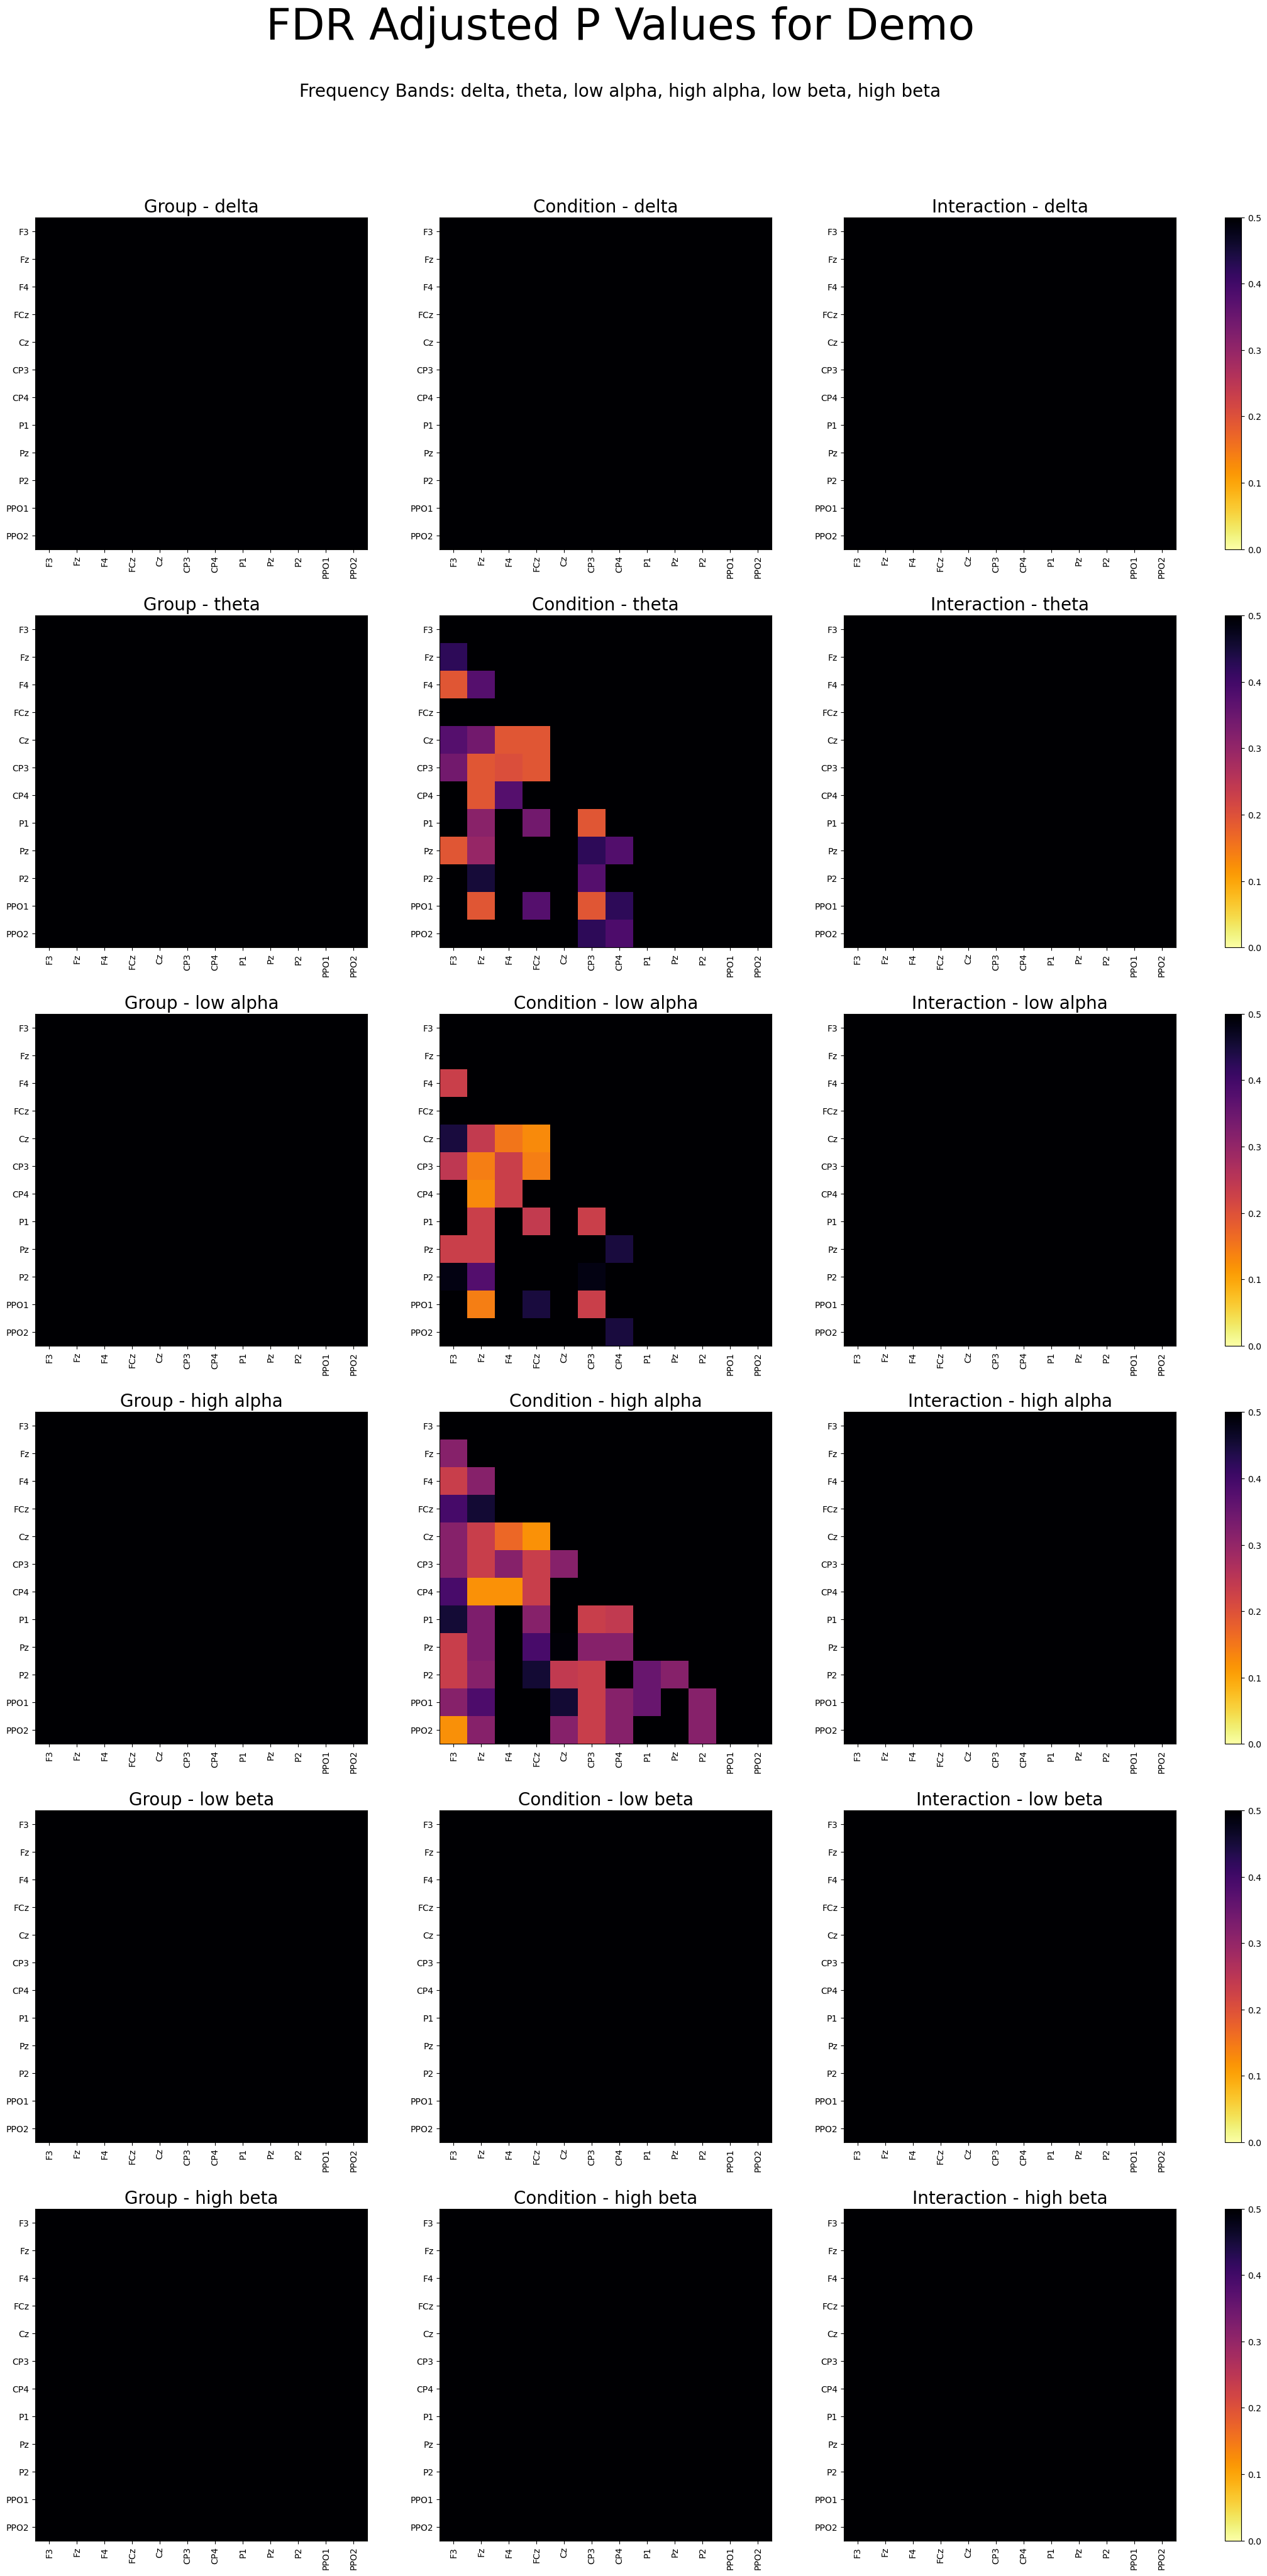

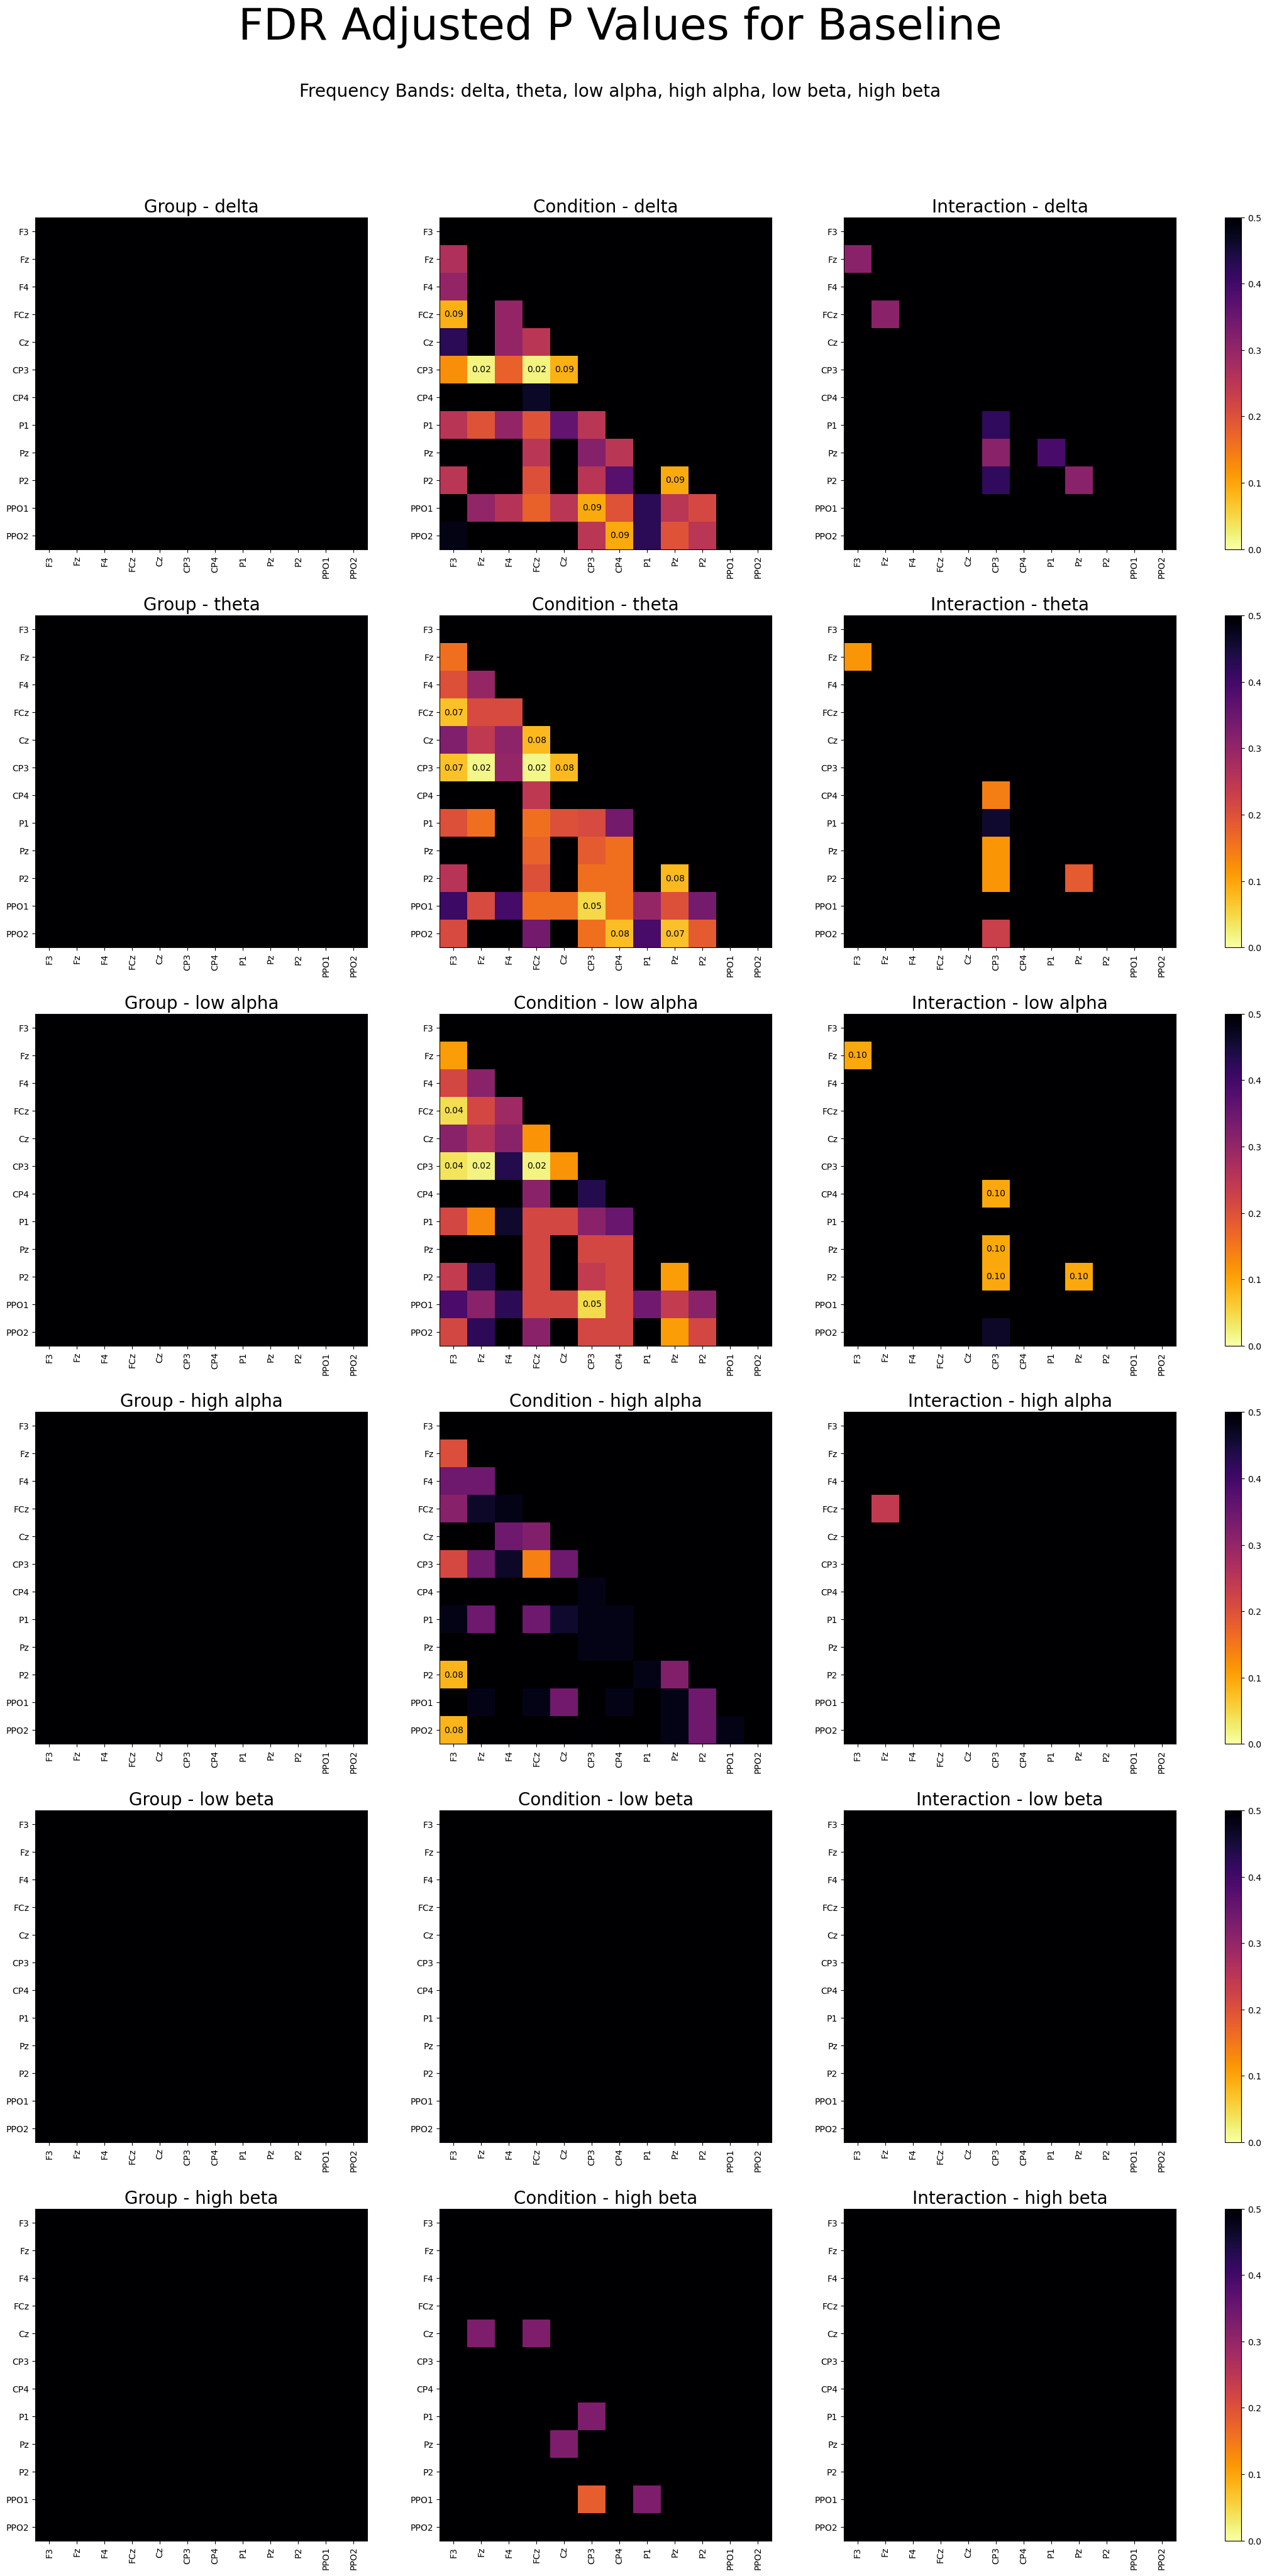

In [145]:
freq_bands = ["delta", "theta", "low alpha", "high alpha", "low beta", "high beta"]

for demo in ["demo", "BL"]:
    ps_groups, ps_conditions, ps_interactions = [], [], []
    for freq_band in freq_bands:
        group_ps, condition_ps, interaction_ps = get_ps(freq_band, demo)
        ps_groups.append(group_ps)
        ps_conditions.append(condition_ps)
        ps_interactions.append(interaction_ps)
    
    title = "FDR Adjusted P Values for Demo" if demo == "demo" else "FDR Adjusted P Values for Baseline"
    plot_all_ps(ps_groups, ps_conditions, ps_interactions, freq_bands, dataset.electrode_names, title=title, sub_title_1="Group", sub_title_2="Condition", sub_title_3="Interaction",save_path=f"plots/{demo}_fdr_adj_p_values.png")